In [ ]:
pwd

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

%cd '/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1'

/content/drive/.shortcut-targets-by-id/1Rg7M7THOvDjEU61yNKx9D4vy-2waHtjs/_한경닷컴/과제/_CNN /작업1


In [ ]:
!unzip -qq '/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/archive.zip'

replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size = 32   # 한셋트에 몇개의 자료를 넣을것인가? 기본 32로 많이하나 조정해도됨. 숫자를 적게할수록 처리속도가 느려짐
img_height = 50
img_width = 50

train_dir='/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/Train'
test_dir='/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/Test'

# 전체 3670개의 이미지자료에서 80%의 2936개를 트레이닝(훈련)자료로 세팅함
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,   # 3670*80%=2936, subset이 training여서 1-0.2임
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)     # 2936개의이미지를 32개씩 세트해서 묶음. 즉 92개세트가 나옴 (92세트*32)

# 전체 3670개의 이미지자료에서 20%의 734개를 테스트데이터로 세팅함
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size)

# train_ds에 할당된 data_dir 폴더명
class_names = train_ds.class_names
print(class_names)

Found 25948 files belonging to 43 classes.
Using 20759 files for training.
Found 25948 files belonging to 43 classes.
Using 5189 files for validation.
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
base_model = VGG16(input_shape=(50,50,3),
                   include_top=False,
                   weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(43,activation='softmax')

In [ ]:
inputs = tf.keras.Input(shape=(50, 50, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 50, 50, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # y값이 원핫인코딩이 안되어 있어서임
              metrics=['accuracy'])


# 모델 최적화를 위한 설정 구간입니다.

modelpath="'flower_CNN_전이학습_에포크100.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, 
                               monitor='val_loss',       # val_loss값을 기준으로
                               verbose=1,                # 실행결과를 화면에 출력함. verbose=0하면 실행결과가 화면에 나타나지않음
                               save_best_only=True)  # 가장좋은(즉 loss숫자가 가장 낮은) 모델을 저장함

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=5) # 실행하다가 5번이상 더 좋은 결과가 없으면 중단

epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_callback,checkpointer]
)

Epoch 1/50
649/649 [==============================] - ETA: 0s - loss: 2.0566 - accuracy: 0.3956

KeyboardInterrupt: ignored

In [ ]:
## 차트작성함
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [ ]:
new_model = tf.keras.models.load_model('')

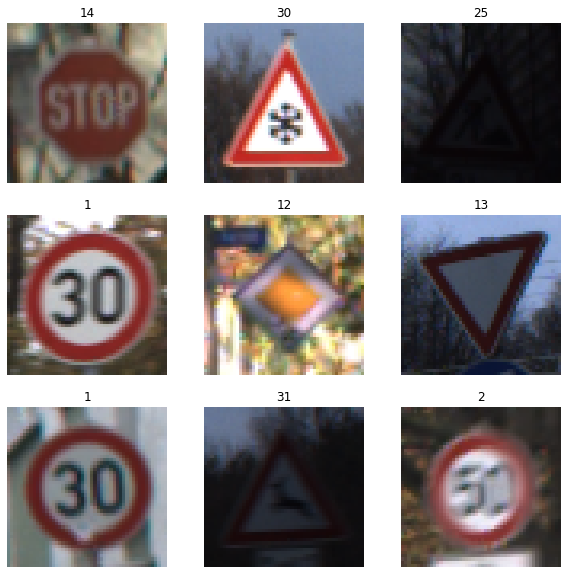

In [ ]:
##########################
### 참고 샘플이미지
##########################
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):   # train_ds.take(1)은 32개의 첫번째 세트을 의미,  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
base_model = VGG16(input_shape=(img_height,img_width,3),
                   include_top=False,
                   weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


In [ ]:
## 클래스 네임의 갯수만큼 
prediction_layer = tf.keras.layers.Dense(43,activation='softmax')  


In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1Rg7M7THOvDjEU61yNKx9D4vy-2waHtjs/_한경닷컴/과제/_CNN /작업1


In [47]:
test=pd.read_csv('/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/Test.csv')
test['index']=[i.replace('Test/','').split('.png')[0] for i in test['Path']]

test['index']

0        00000
1        00001
2        00002
3        00003
4        00004
         ...  
12625    12625
12626    12626
12627    12627
12628    12628
12629    12629
Name: index, Length: 12630, dtype: object

Found 26811 files belonging to 43 classes.
Using 21449 files for training.
Found 26811 files belonging to 43 classes.
Using 5362 files for validation.
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


1/1 [==============================] - 0s 131ms/step


IndexError: ignored

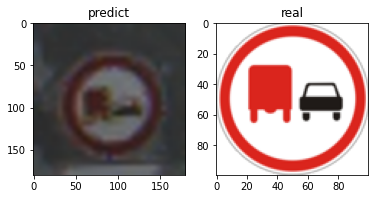

In [49]:
## 예측해보기 'ㅅ'* 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd 
from PIL import Image 
from glob import glob
import numpy as np 

batch_size = 32   # 한셋트에 몇개의 자료를 넣을것인가? 기본 32로 많이하나 조정해도됨. 숫자를 적게할수록 처리속도가 느려짐
img_height = 50
img_width = 50

train_dir='/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/Train'
test_dir='/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/Test'

# 전체 3670개의 이미지자료에서 80%의 2936개를 트레이닝(훈련)자료로 세팅함
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,   # 3670*80%=2936, subset이 training여서 1-0.2임
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)     # 2936개의이미지를 32개씩 세트해서 묶음. 즉 92개세트가 나옴 (92세트*32)

# 전체 3670개의 이미지자료에서 20%의 734개를 테스트데이터로 세팅함
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size)

# train_ds에 할당된 data_dir 폴더명
class_names = train_ds.class_names
print(class_names)

model = tf.keras.models.load_model('/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/독일 교통표지판.hdf5')
 
file_list=glob('/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/test/*.png')
meta=pd.read_csv('/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/Meta.csv')
test=pd.read_csv('/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/Test.csv')
test['index']=[i.replace('Test/','').split('.png')[0] for i in test['Path']]
for file in file_list[:30]:
  img=Image.open(file)
  img=img.resize((180,180))
  imgArr=np.array(img)
  inputimage=imgArr.reshape(1,180,180,3)
  predictNum=model.predict(inputimage) 
  num=np.argmax(predictNum)
  classfiled=class_names[num]

  plt.subplot(121)
  plt.title('predict')
  plt.imshow(img)
  
  plt.subplot(122)
  plt.title('real')
  path='/content/drive/MyDrive/_한경닷컴/과제/_CNN /작업1/'
  a=Image.open(path+meta[meta['ClassId'] == int(class_names[num])]['Path'].values[0])
  plt.imshow(a)

  real_class=test[test['index']==int(file.split('/')[-1].replace('.png',''))]['ClassId']
  if int(classfiled)==real_class.values[0]:
    print('정답')
  else:
    print('오답')
  plt.show()

In [9]:
pwd

'/content/drive/.shortcut-targets-by-id/1Rg7M7THOvDjEU61yNKx9D4vy-2waHtjs/_한경닷컴/과제/_CNN /작업1'